In [16]:
import argparse
import pickle
import datasets
from datasets import load_dataset
import os
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

DATASET_PATH = {
    'p3': 'simonycl/p3_0.5_dataset'
}
METHODS = ['Uniform', 'Random', 'KMeansRandom', 'KMeansCentroids']

[Text(0.5, 1.0, 'Histogram of the length of examples in P3')]

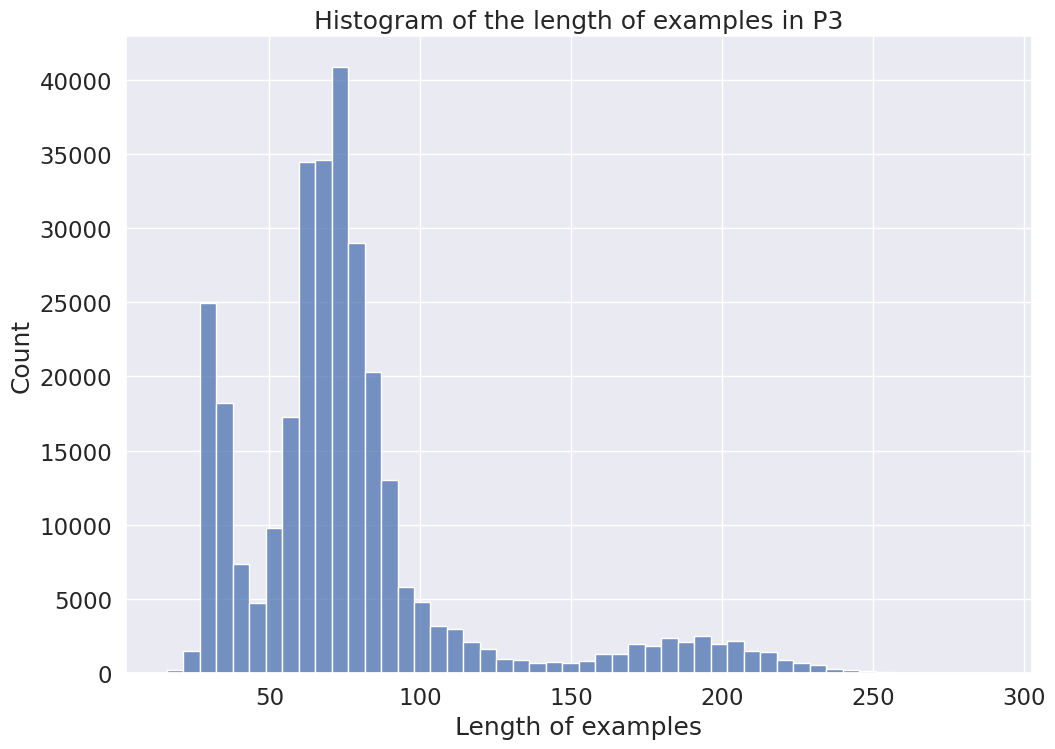

In [29]:
dataset_name = 'p3'
dataset_path = DATASET_PATH[dataset_name]
if dataset_path.endswith('json') or dataset_path.endswith('jsonl'):
    dataset = load_dataset('json', data_files=dataset_path)
elif dataset_path.endswith('csv'):
    dataset = load_dataset('csv', data_files=dataset_path)
else:
    dataset = load_dataset(dataset_path)

dataset = dataset['train']

processed_dataset = dataset.map(lambda x: {'length': len(x['input'].split())}, remove_columns=dataset.column_names)

df_len_sharegpt = processed_dataset.to_pandas()

sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(font_scale=1.5)
ax = sns.histplot(data=df_len_sharegpt, x="length", bins=50)
# ax.set(xlim=(0, 8000))
# ax.set(ylim=(0, 10000))
ax.set(xlabel='Length of examples')
ax.set(ylabel='Count')
ax.set(title='Histogram of the length of examples in P3')

In [18]:
dataset_name = 'p3'
indices_path = 'indices'
portion = 0.1
output_path = 'plots'

datasets = ["RTE","CB","ANLI_R1","ANLI_R2","ANLI_R3","COPA","HELLASWAG","STORYCLOZE","WINOGRANDE","WSC","WIC"]


In [30]:
results = pd.read_csv('/mnt/data/data-selection/selection/results.csv')

# remove the average column
non_average_results = results.drop(columns=['Avgerge'])
# non_average_results
non_average_results
# set the column name into ['Method'] + datasets
non_average_results.columns = ['Method'] + datasets
non_average_results

,Method,RTE,CB,ANLI_R1,ANLI_R2,ANLI_R3,COPA,HELLASWAG,STORYCLOZE,WINOGRANDE,WSC,WIC
0,LLaMA-2-7B,53.43,28.57,37.3,35.3,36.00,54,24.83,51.56,50.11,51.92,52.82
1,Full,88.09,91.07,77.2,58.7,57.90,63,65.69,64.29,79.40,64.42,73.04
2,Uniform,79.78,78.58,58.6,46.6,45.92,52,26.33,57.22,49.01,58.65,54.86
3,Random,70.76,73.21,58.9,48.2,48.17,57,26.39,57.35,48.93,54.81,52.51
4,KMeansCentroids,80.87,83.93,61.3,48.0,47.58,51,27.14,57.29,49.48,57.69,52.66
5,KMeansRandom,71.19,67.86,60.1,46.8,46.58,49,26.77,57.54,48.54,58.65,52.98


In [20]:
dataset_path = DATASET_PATH[dataset_name]
if dataset_path.endswith('json') or dataset_path.endswith('jsonl'):
    dataset = load_dataset('json', data_files=dataset_path)
elif dataset_path.endswith('csv'):
    dataset = load_dataset('csv', data_files=dataset_path)
else:
    dataset = load_dataset(dataset_path)

dataset = dataset['train']

method2indices = {}
for method in METHODS:
    if os.path.exists(os.path.join(indices_path, f'{dataset_name}_{method}_{portion}.pkl')):
        with open(os.path.join(indices_path, f'{dataset_name}_{method}_{portion}.pkl'), 'rb') as f:
            method2indices[method] = pickle.load(f)
    else:
        print(f'{dataset}_{method}_{portion}.pkl does not exist')
method2indices['full'] = list(range(len(dataset)))

method2counters = {}
method2indices_extra = {}
for method, indices in method2indices.items():
    if isinstance(indices, dict):
        indices = indices['indices']
    print(method, len(indices))
    method2indices_extra[method] = indices
    subset = dataset.select(indices)
    # get the distribution of subset['category']
    counter = dict(Counter(subset['dataset']))
    # plot the distribution
    method2counters[method] = counter
    # counter['method'] = method
    # method2counters.append(counter)

counters = []
precentage_counters = []
for method, counter in method2counters.items():
    if method == 'full':
        continue
    precentage = {}
    for key in counter:
        precentage[key] = counter[key] / method2counters['full'][key]
    counter['method'] = method
    precentage['method'] = method
    counters.append(counter)
    precentage_counters.append(precentage)


Uniform 30490
Random 30496
KMeansRandom 30486
KMeansCentroids 30496
full 304955


In [32]:
df = pd.DataFrame(counters)
# df = df.melt(id_vars=['method'], var_name='dataset', value_name='count')
df
df_results = non_average_results.melt(id_vars=['Method'], var_name='dataset', value_name='results')
df_results['Method'].unique()

array(['LLaMA-2-7B', 'Full', 'Uniform', 'Random', 'KMeansCentroids',
       'KMeansRandom'], dtype=object)

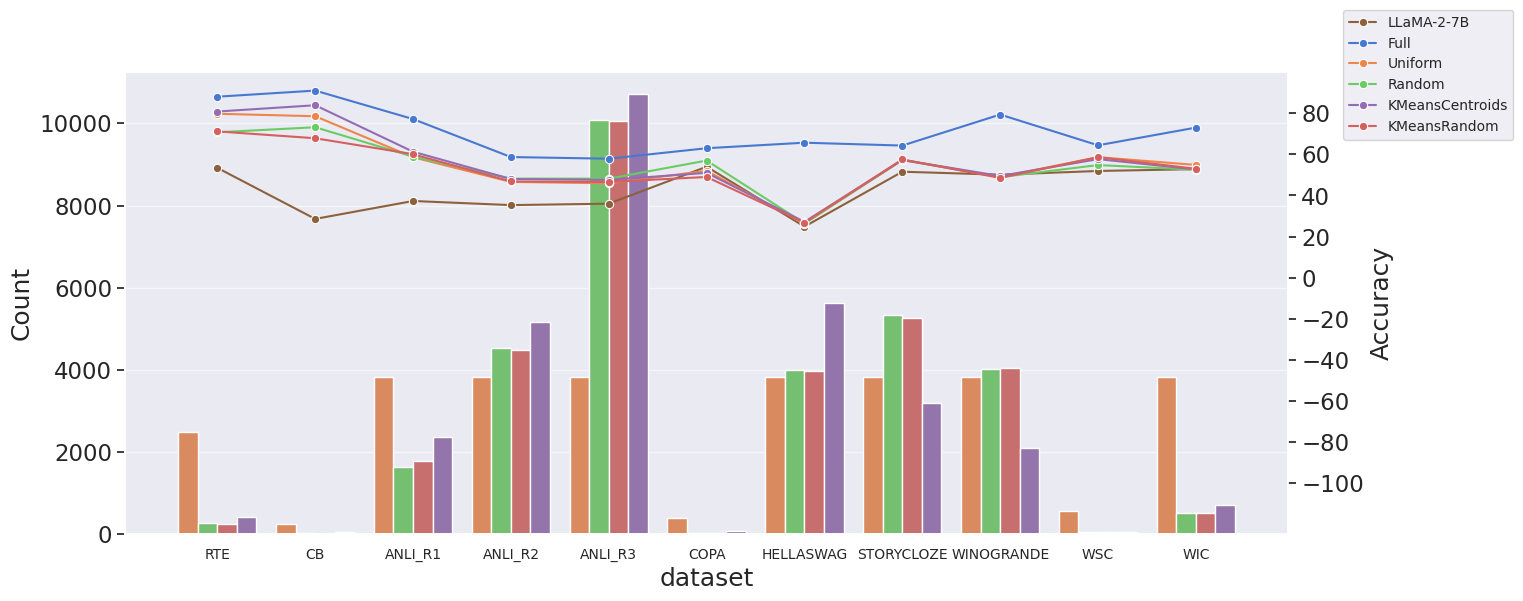

In [64]:
import numpy as np

# TODO ideas: plot the performance above the barchart

colors = sns.color_palette('muted')
colors_map = {
    'Full': colors[0],
    'Uniform': colors[1],
    'Random': colors[2],
    'KMeansRandom': colors[3],
    'KMeansCentroids': colors[4],
    'LLaMA-2-7B': colors[5],
}

# plot the distribution

df = pd.DataFrame(counters)
fig, ax = plt.subplots(figsize=(15, 6))
df = df.melt(id_vars=['method'], var_name='dataset', value_name='count')
# upper case all the dataset names
df['dataset'] = df['dataset'].apply(lambda x: x.upper())
# sort the dataset names based on the array datasets
df['dataset'] = pd.Categorical(df['dataset'], categories=datasets)
# take the log of the count
df['Log Count'] = np.log(df['count'])
df['Count'] = df['count']
# rename the method names to Method
df['Method'] = df['method']
# drop the method column
df = df.drop(columns=['method'])
# compute the total across all datasets
df_total = df.drop(columns=['dataset']).groupby(['Method']).sum().reset_index()
# sns.barplot(x='dataset', y='Log Count', hue='Method', data=df, ax=ax, palette=colors_map, legend=False)
sns.barplot(x='dataset', y='Count', hue='Method', data=df, ax=ax, palette=colors_map, legend=False)

# dim the grid
ax.grid(True, alpha=0.6, axis='y')
# ax.set_ylim([0, 14])
ax1 = ax.twinx()
# plot the results on the right axis

sns.lineplot(x='dataset', y='results', hue='Method', data=df_results, ax=ax1, marker='o', legend=True, palette=colors_map)
# set the y lim for ax1 be [0, 100]
ax1.set_ylim([-125, 100])
# not show y labels from -100 to 0
ax1.set_yticks(np.arange(-100, 100, 20))
# change the y label to be Accuracy
ax1.set_ylabel('Accuracy')
# set ax1 grid behind
ax1.grid(False)

# put the legend on the right top
ax1.legend(loc='upper right', bbox_to_anchor=(1.20, 1.15), fontsize=10)

# smaller the x tick labels
ax.tick_params(axis='x', labelsize=10)

Text(0.5, 0, 'Dataset')

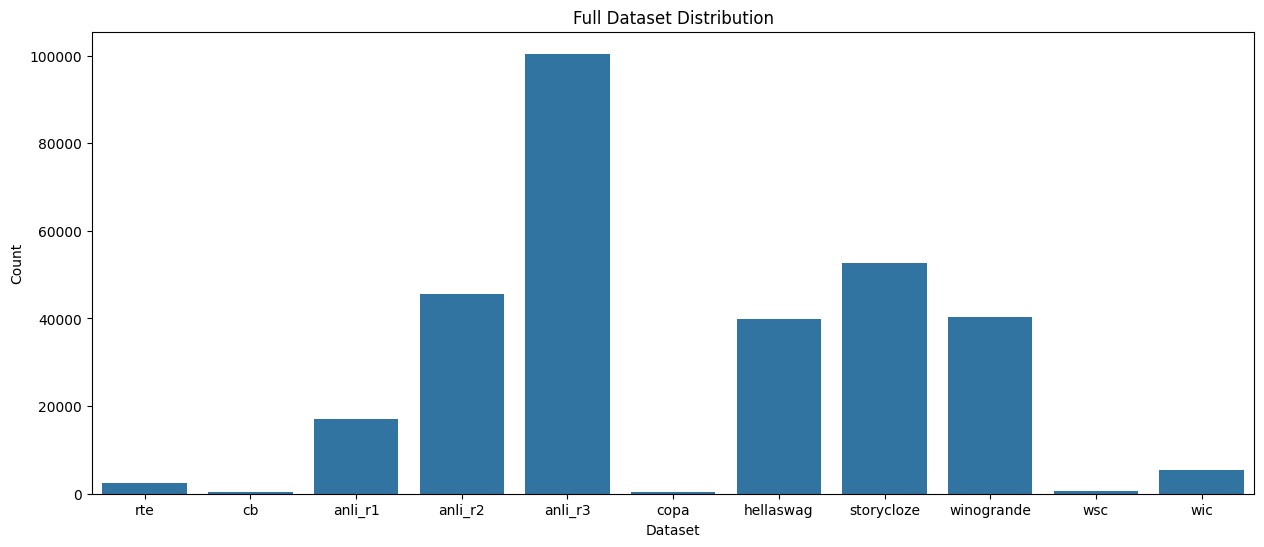

In [30]:
# plot method2counters['full']
fig, ax = plt.subplots(figsize=(15, 6))

sns.barplot(data=method2counters['full'], x=list(method2counters['full'].keys()), y=list(method2counters['full'].values()), ax=ax)
ax.set_title('Full Dataset Distribution')
ax.set_ylabel('Count')
ax.set_xlabel('Dataset')

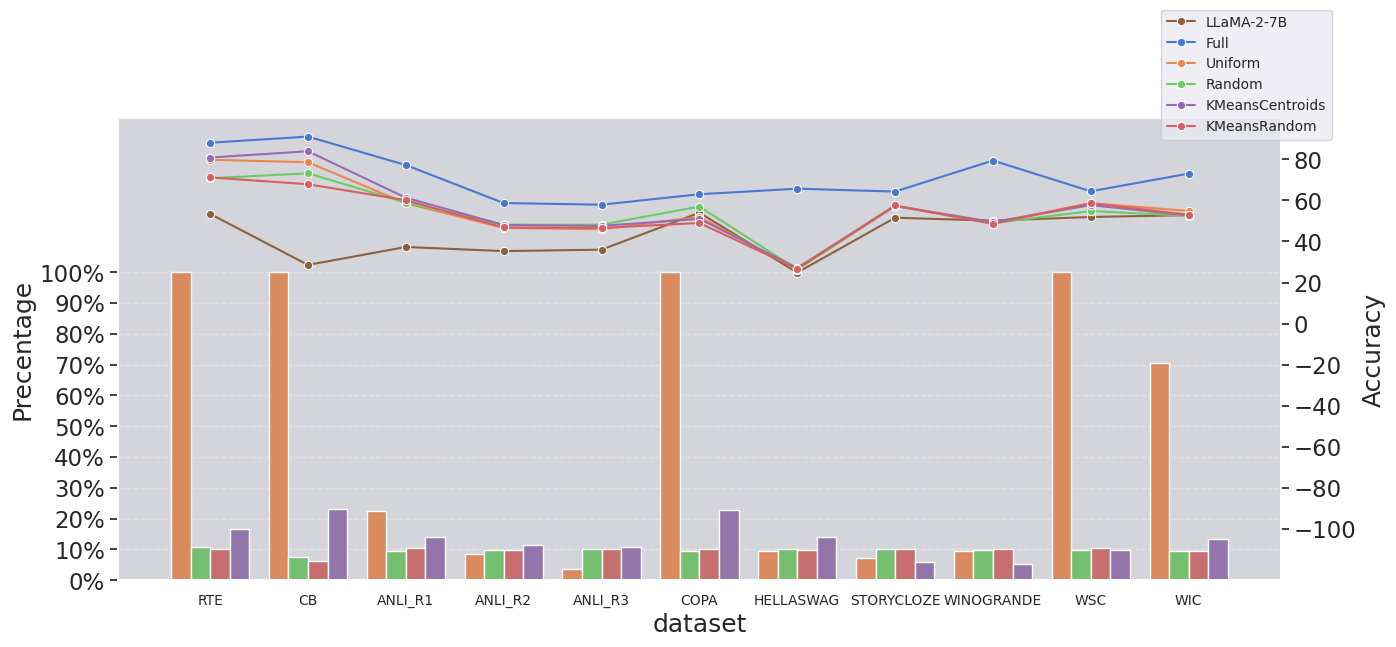

In [57]:
df = pd.DataFrame(precentage_counters)
fig, ax = plt.subplots(figsize=(15, 6))
df = df.melt(id_vars=['method'], var_name='dataset', value_name='precentage')
df['dataset'] = df['dataset'].apply(lambda x: x.upper())
df['dataset'] = pd.Categorical(df['dataset'], categories=datasets)
df['Method'] = df['method']
df['Precentage'] = df['precentage']
# add grid behind the plot
ax.grid(axis='y', linestyle='--', alpha=0.5)
# add grey background
ax.axhspan(0, 1.5, facecolor='grey', alpha=0.2)
# set the y ticket labels to be 10% 20% ...
ax.set_yticks(np.arange(0, 1.1, 0.1))
sns.barplot(x='dataset', y='Precentage', hue='Method', data=df, ax=ax, palette=colors_map, legend=False)
# modify the legend position
# ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
ax.set_ylim([0, 1.5])
ax.grid(True, alpha=0.8, axis='y')
# turn the y labels to *100 and add %
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
ax1 = ax.twinx()
# plot the results on the right axis

sns.lineplot(x='dataset', y='results', hue='Method', data=df_results, ax=ax1, marker='o', legend=True, palette=colors_map)
# set the y lim for ax1 be [0, 100]
ax1.set_ylim([-125, 100])
# not show y labels from -100 to 0
ax1.set_yticks(np.arange(-100, 100, 20))
ax1.grid(False)
# change the y label to be Accuracy
ax1.set_ylabel('Accuracy')
# put the legend on the right top
ax1.legend(loc='upper right', bbox_to_anchor=(1.05, 1.25), fontsize=10)
# smaller font size for the x tick labels
ax.tick_params(axis='x', labelsize=10)

In [19]:
# Analyse the overlap of data between methods
# measure the overlap of list between Uniform and KMeansCentroids
# METHODS = ['Uniform', 'Random', 'kmeansrandom', 'KMeansCentroids']
method1 = 'KMeansCentroids'
method2 = 'kmeansrandom'
indices1 = method2indices_extra[method1]
indices2 = method2indices_extra[method2]
print(len(indices1), len(indices2))
print(len(set(indices1).intersection(set(indices2))))
print(len(set(indices1).union(set(indices2))))
print(len(set(indices1).difference(set(indices2))))
print(len(set(indices2).difference(set(indices1))))

30496 30487
3057
57234
26747
27430
